# import library

In [1]:
import os
import mmcv
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import skimage.io as io
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from glob import glob
from mmcv.ops import nms
from ipywidgets import interact
from mmcv import Config, DictAction
from mmdet.datasets import build_dataset
from matplotlib.ticker import MultipleLocator
from mmdet.core.evaluation.bbox_overlaps import bbox_overlaps


# GT, Predict wrong, right 시각화

In [2]:
config_path = '/opt/ml/detection/baseline/mmdetection/configs/1_mymodel/retinanet_r50_fpn_1x_coco.py'
# '/opt/ml/detection/baseline/mmdetection/configs/my_model/faster_rcnn_r50_fpn_1x_coco_custom.py'

prediction_path = '/opt/ml/detection/baseline/mmdetection/work_dirs/swin_retinanet/result.pkl'
# '/opt/ml/detection/baseline/mmdetection/work_dirs/test/result.pkl'

# default_setting
color_theme='plasma'
score_thr = 0.3
tp_iou_thr = 0.5
nms_iou_thr = None
palette = sns.color_palette('bright')
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

In [3]:
cfg = Config.fromfile(config_path)

results = mmcv.load(prediction_path)
assert isinstance(results, list)
if isinstance(results[0], list):
    pass
elif isinstance(results[0], tuple):
    results = [result[0] for result in results]
else:
    raise TypeError('invalid type of prediction results')

if isinstance(cfg.data.test, dict):
    cfg.data.test.test_mode = True
elif isinstance(cfg.data.test, list):
    for ds_cfg in cfg.data.test:
        ds_cfg.test_mode = True
dataset = build_dataset(cfg.data.test)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [15]:
def pltSetting(ax, fname):
    title = ['GT', 'FN', 'TP', 'FP']
    img = io.imread(fname)
    for i in range(4):
        ax[i].imshow(img)
        
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
        ax[i].set_title(title[i])


In [18]:
@interact(img_idx=(0, len(results)-1), score_thr=(0., 1., 0.05), tp_iou_thr=(0., 1., 0.05), cls_num=(0, 10))
def calculate_confusion_matrix(img_idx=0, score_thr=0,tp_iou_thr=0.5, cls_num=10):
    """Calculate the confusion matrix.

    Args:
        dataset (Dataset): Test or val dataset.
        results (list[ndarray]): A list of detection results in each image.
        score_thr (float|optional): Score threshold to filter bboxes.
            Default: 0.
        nms_iou_thr (float|optional): nms IoU threshold, the detection results
            have done nms in the detector, only applied when users want to
            change the nms IoU threshold. Default: None.
        tp_iou_thr (float|optional): IoU threshold to be considered as matched.
            Default: 0.5.
    """

    nms_iou_thr=None
    num_classes = len(dataset.CLASSES)
    confusion_matrix = np.zeros(shape=[num_classes + 1, num_classes + 1])
    assert len(dataset) == len(results)

    per_img_res = results[img_idx]
    
    fname = dataset[img_idx]['img_metas'][0].data['filename'] 
    # 차례대로 fname을 가져온다.
    
    if isinstance(per_img_res, tuple):
        res_bboxes, _ = per_img_res
    else:
        res_bboxes = per_img_res
    ann = dataset.get_ann_info(img_idx)
    gt_bboxes = ann['bboxes']
    gt_labels = ann['labels']
    
    # analyze_per_img_dets(fname, confusion_matrix, gt_bboxes, gt_labels, res_bboxes, cls_num,
    #                         score_thr, tp_iou_thr, nms_iou_thr) # cls_num, fname

    true_positives = np.zeros_like(gt_labels)
    
    fig, ax = plt.subplots(2, 2, dpi=250)
    ax = ax.flatten()
    pltSetting(ax, fname)

    for gt_label_idx, gt_bbox in enumerate(gt_bboxes):
        gt_label = gt_labels[gt_label_idx]
        x,y,x1,y1 = gt_bbox[:4]
        ax[0].add_patch(
                patches.Rectangle(
                    (x,y), x1-x, y1-y,
                    edgecolor=palette[gt_label],
                    linewidth=1,
                    fill=False,
                ),
            )
        text_y = y-30 if y>30 else y+30
        plt_text = ax[0].text(x+18,text_y, f'{classes[gt_label]}', color='white', fontsize='4', weight='semibold')
        plt_text.set_bbox(dict(
            facecolor=palette[gt_label],  # background color
            alpha=0.6,  # background alpha
            edgecolor='none',  # border color
            pad=2
        ))

    False_negatives = np.zeros_like(gt_labels)

    for det_label, det_bboxes in enumerate(res_bboxes):
        if(cls_num!=10 and cls_num!=det_label):
             continue 

        ious = bbox_overlaps(det_bboxes[:, :4], gt_bboxes)

        # 모든 pred와 gt iou 계산
        for i, det_bbox in enumerate(det_bboxes):
            score = det_bbox[4]
            x,y,x1,y1 = det_bbox[:4]
            det_match = 0
            if score >= score_thr:
                # score가 threshold보다 낮은 거 기본적으로 제거
                for j, gt_label in enumerate(gt_labels):
                    if ious[i, j] >= tp_iou_thr:
                        # 만약 i번째 detected box와 j번째 gt box의 겹치는 정도가 tp_iou_thr보다 크다면 match시켜줌
                        if gt_label == det_label:
                            # 만약 gt와 detection의 라벨이 같다면
                            False_negatives[j]+=1
                            det_match += 1
                if det_match == 0:  # BG FP
                    # gt와 detection이 match된 게 1개도 없다면 Background 1 증가,
                    ax_idx = 3
                else:
                    ax_idx = 2

                ax[ax_idx].add_patch(
                        patches.Rectangle(
                            (x,y), x1-x, y1-y,
                            edgecolor=palette[det_label],
                            linewidth=1,
                            fill=False,
                        ),
                    )
                text_y = y-30 if y>30 else y+30
                plt_text = ax[ax_idx].text(x+18,text_y, f'{classes[det_label]}', color='white', fontsize='4', weight='semibold')
                plt_text.set_bbox(dict(
                    facecolor=palette[det_label],  # background color
                    alpha=0.6,  # background alpha
                    edgecolor='none',  # border color
                    pad=2
                ))

    for gt_label_idx, gt_bbox in enumerate(gt_bboxes):
        if False_negatives[gt_label_idx]!=0:
            continue
        gt_label = gt_labels[gt_label_idx]
        x,y,x1,y1 = gt_bbox[:4]
        ax[1].add_patch(
                patches.Rectangle(
                    (x,y), x1-x, y1-y,
                    edgecolor=palette[gt_label],
                    linewidth=1,
                    fill=False,
                ),
            )
        text_y = y-30 if y>30 else y+30
        plt_text = ax[1].text(x+18,text_y, f'{classes[gt_label]}', color='white', fontsize='4', weight='semibold')
        plt_text.set_bbox(dict(
            facecolor=palette[gt_label],  # background color
            alpha=0.6,  # background alpha
            edgecolor='none',  # border color
            pad=2
        ))

        



interactive(children=(IntSlider(value=0, description='img_idx', max=571), FloatSlider(value=0.0, description='…

In [ ]:
("General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# 틀린 ground truth 통계치 구하기

In [8]:
result_df_path = '/opt/ml/detection/baseline/mmdetection/work_dirs/swin_retinanet/wrong_bbox.csv'
result_df = pd.read_csv(result_df_path)

result_df['label'] = result_df['label'].apply(lambda x : classes[x])
result_df.head(10)

,fname,label,area,aspect_ratio,bbox_x_min,bbox_y_min,bbox_x_max,bbox_y_max
0,/opt/ml/detection/dataset/train/0042.jpg,Plastic,1090.40010,1.296552,770.3,421.9,799.3,459.5
1,/opt/ml/detection/dataset/train/0042.jpg,General trash,789.37006,0.471884,750.7,479.8,791.6,499.1
2,/opt/ml/detection/dataset/train/0042.jpg,General trash,1226.16200,1.259616,397.0,541.1,428.2,580.4
3,/opt/ml/detection/dataset/train/0062.jpg,Plastic bag,118532.56000,2.302336,0.0,404.8,226.9,927.2
4,/opt/ml/detection/dataset/train/0062.jpg,Plastic,14162.40200,0.717438,752.4,440.9,892.9,541.7
5,/opt/ml/detection/dataset/train/0062.jpg,Plastic,18135.09400,1.045558,609.2,337.3,740.9,475.0
6,/opt/ml/detection/dataset/train/0062.jpg,General trash,8261.10000,0.543390,394.2,640.5,517.5,707.5
7,/opt/ml/detection/dataset/train/0062.jpg,General trash,2842.10030,0.827645,239.4,655.5,298.0,704.0
8,/opt/ml/detection/dataset/train/0062.jpg,General trash,5709.06640,0.408630,321.4,664.1,439.6,712.4
9,/opt/ml/detection/dataset/train/0062.jpg,General trash,45737.79300,0.497856,174.7,692.1,477.8,843.0


# class 별로 못 맞춘 instance min, max, mean 넓이 구하기

In [9]:
min_area_per_class = result_df.groupby(['label'])['area'].min()
max_area_per_class = result_df.groupby(['label'])['area'].max()
mean_aera_per_class = result_df.groupby(['label'])['area'].mean()
area_df = pd.DataFrame(columns=['min_area', 'max_area', 'mean_area'])
area_df['min_area']=min_area_per_class
area_df['max_area']=max_area_per_class
area_df['mean_area']=mean_aera_per_class
print(area_df)

                 min_area     max_area     mean_area
label                                               
Battery        1839.14880    17349.752  11921.473600
Clothing        867.92126   563105.440  74338.699226
General trash   562.94977  1047961.700  35280.382768
Glass          1686.81840    70205.630  12102.063932
Metal           952.20056   103005.836  23388.696046
Paper           475.38116  1047961.700  34392.976640
Paper pack     1280.27950   900676.940  50514.490059
Plastic         426.40040   877720.440  28455.410837
Plastic bag     742.25946   824180.900  36033.306154
Styrofoam      1064.99940   992374.800  70752.302898


# class 별로 못 맞춘 instance 영역 분포

<AxesSubplot:xlabel='area', ylabel='label'>

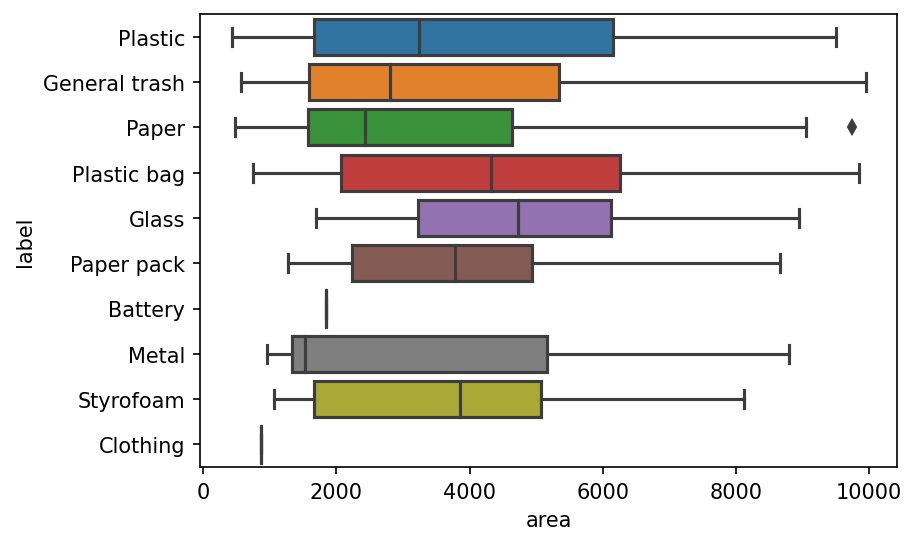

In [13]:
threshold = 10000
cut_result_df =  result_df[result_df['area']<threshold]
fig, ax = plt.subplots(1, 1, dpi = 150)
sns.boxplot(data=cut_result_df, x='area', y='label', dodge=True, ax=ax)
# 최대값을 0.1로 짜르자